In [1]:
!pip install mplcyberpunk

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import nltk
import matplotlib.pyplot as plt
import mplcyberpunk  

plt.style.use(["dark_background", "cyberpunk"])

In [3]:
import os
from collections import Counter
from nltk.tokenize import PunktSentenceTokenizer, TweetTokenizer

def read_text(paths):
    documents = []
    for root, dirs, files in os.walk(paths):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    lines = f.readlines()
                    content = ''.join(lines)
                    documents.append(content)
            except UnicodeDecodeError:
                print(f"Error reading file: {file_path}")      
    return '\n'.join(documents)

def clear(text: str) -> None:
    counter = Counter()
    vocab = {'<EOS>', '<BOS>', '<UNK>'}
    sentence_tokenizer = PunktSentenceTokenizer()
    punct_tokenizer = TweetTokenizer()
    new_sentences = []
    for sentence in sentence_tokenizer.tokenize(text):
        if '"' not in sentence:
            words = punct_tokenizer.tokenize(sentence.replace('\\', ''))
            for word in words:
                counter[word] += 1
            if len(words) > 4:
                new_sentences.append(words)
    for w, c in counter.items():
        if c > 100:
            vocab.add(w)
    return new_sentences, vocab

In [4]:
path = 'bbc-news-summary/'

In [5]:
from sklearn.model_selection import train_test_split

origin_text = read_text(path)

sentences, vocab = clear(origin_text)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.3)

word2ind = {char: ind for ind, char in enumerate(vocab)}
ind2word = {ind: char for char, ind in word2ind.items()}

In [6]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    
    def __init__(self, sentences: list) -> None:
        self.data = sentences
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int) -> str:
        return self.data[index]
    

def collate(input_batch: list, char_to_ind: dict, mode='char'):
    if mode == 'char':
        seq_lens = [len(list(sent)) for sent in input_batch]
    elif mode == 'word':
        seq_lens = [len(x) for x in input_batch]   
    max_seq = max(seq_lens)
    new_batch = []
    masks = []
    for sequence in input_batch:
        new_sequence = [char_to_ind['<BOS>'], ]
        mask = [1, ]
        first = True
        for i in range(max_seq):
            if i < len(sequence):
                if sequence[i] in char_to_ind:
                    new_sequence.append(char_to_ind[sequence[i]])
                    mask.append(1)
                else:
                    new_sequence.append(char_to_ind['<UNK>'])
                    mask.append(0)
            else:
                if first:
                    mask.append(1)
                    first = False
                else:
                    mask.append(0)
                new_sequence.append(char_to_ind['<EOS>'])
        new_sequence.append(char_to_ind['<EOS>'])
        if len(sequence) == max_seq:
            mask.append(1)
        else:
            mask.append(0)
        new_batch.append(new_sequence)
        masks.append(mask)
    sequences = torch.LongTensor(new_batch)
    masks = torch.Tensor(masks)
    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:],
        'masks': masks[:, 1:]
    }
    return new_batch

In [7]:
from torch.utils.data import DataLoader, Dataset
from functools import partial

train_dataset = TextDataset(train_sentences)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=partial(collate, char_to_ind=word2ind, mode='word'))

val_dataset = TextDataset(val_sentences)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=partial(collate, char_to_ind=word2ind, mode='word'))

In [8]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab, num_lstm_layers=1, hidden_dim=128, dropout=0.1, bidirectional=False):
        super().__init__()
        self.embed_dim = 400
        self.hidden_dim = hidden_dim
        self.vocab_size = len(vocab)
        self.embed_layer = nn.Embedding(self.vocab_size, self.embed_dim)
        self.recurrent_layer = nn.LSTM(self.embed_dim, self.hidden_dim, batch_first=True, num_layers=num_lstm_layers, bidirectional=bidirectional)
        self.linear_layer = nn.Linear(pow(2, bidirectional) * self.hidden_dim, pow(2, bidirectional) * self.hidden_dim)
        self.projection = nn.Linear(pow(2, bidirectional) * self.hidden_dim, self.vocab_size)
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embed_layer(input_batch)
        x, _ = self.recurrent_layer(x)
        x = self.dropout_layer(self.linear_layer(self.relu(x)))
        x = self.projection(x).permute(0, 2, 1)
        return x

In [9]:
from tqdm import tqdm
import mplcyberpunk
from IPython.display import clear_output

def train_model(model, criterion, optimizer, dataloader, epochs=2):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    train_history = []
    for i in range(epochs):
        for j, batch in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits.cpu(), batch['target_ids'])
            masked_loss = loss * batch['masks']
            total_loss = masked_loss.sum() / batch['masks'].sum()
            total_loss.backward()
            optimizer.step()
            train_history.append((i * len(dataloader) * len(batch) + j * len(batch), total_loss.item()))
            clear_output(True)
            plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
            plt.legend(); plt.grid(); plt.show()        
            
def validate_model(model, criterion, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits.cpu(), batch['target_ids'])
            masked_loss = loss * batch['masks']
            total_loss = masked_loss.sum() / batch['masks'].sum()
            perplexity.append(torch.exp(total_loss).item())
    perplexity = sum(perplexity) / len(perplexity)
    return perplexity

In [10]:
model = LSTMModel(word2ind, num_lstm_layers=3, hidden_dim=256, dropout=0.2, bidirectional=True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=3e-4)

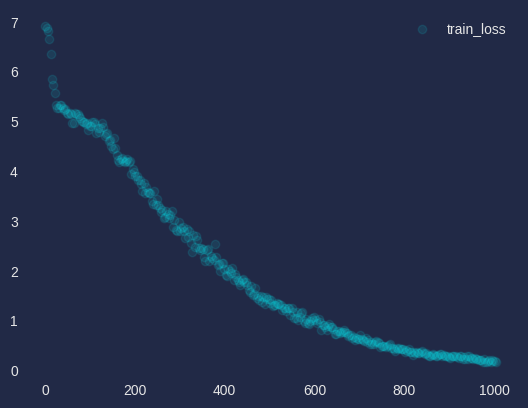

100%|██████████| 336/336 [18:36<00:00,  3.32s/it]


In [11]:
train_model(model, criterion, optimizer, train_loader, epochs=1)

In [12]:
validate_model(model, criterion, val_loader)

100%|██████████| 144/144 [02:01<00:00,  1.19it/s]


1.1647192471557193

In [13]:
import numpy as np

def inference_word(model, text, word2ind, ind2word, temperature=0.0):    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    punct_tokenizer = TweetTokenizer()
    words = punct_tokenizer.tokenize(text)
    with torch.no_grad():
        while True:
            batch = collate([words], word2ind, mode='word')
            last_logits = model(batch['input_ids'].to(device))[0, :, -1]
            probs = torch.softmax(last_logits, 0).cpu()
            if temperature == 0.0:
                next_token = ind2word[torch.argmax(probs, 0).item()]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(list(word2ind.keys()), p=probs)
            if next_token == '<EOS>' or len(words) == 30:
                break
            words.append(next_token)
    return ' '.join(words)

In [14]:
inference_word(model, 'A Christmas tree ', word2ind, ind2word, temperature=1.7)

'A Christmas tree With South Christmas great American summer believes within turn age firm goal goal 4 phone research Street six general deficit goal second boss League August 2 !'